# Generate composite galaxy

Finall, in this example we're going to demonstrate how to make a composite galaxy, including with imaging. For more information on defining parametric morphology see the Imaging examples.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from unyt import Myr, kpc, angstrom, Msun

from synthesizer.emission_models import IncidentEmission
from synthesizer.filters import UVJ
from synthesizer.grid import Grid
from synthesizer.parametric import SFH, Stars, ZDist
from synthesizer.parametric.galaxy import Galaxy
from synthesizer.parametric.morphology import Sersic2D

Let's begin by defining the geometry of the images:

In [2]:
# Define geometry of the images
resolution = 0.1 * kpc  # resolution in kpc
npix = 50
fov = resolution * npix

And initialising the `Grid` object:

In [3]:
grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=np.logspace(3, 4.2, 1000) * angstrom)

And initialising a `FilterCollection`, in this case the rest-frame UVJ filters.

In [4]:
filters = UVJ(new_lam=grid.lam)

## Disk

Let's now build the disk component of our composite galaxy.

Starting by defining the morphology:

In [5]:
morph = Sersic2D(
    r_eff=2.0 * kpc, sersic_index=1.0, ellipticity=0.5, theta=35.0
)

Define the parameters of the star formation and metal enrichment histories

In [6]:
sfh_p = {"max_age": 10 * Myr}
Z_p = {
    "log10metallicity": -2.0
}  # can also use linear metallicity e.g. {'Z': 0.01}
stellar_mass = 10**9.5 * Msun

Define the functional form of the star formation and metal enrichment histories

In [7]:
sfh = SFH.Constant(**sfh_p)  # constant star formation
metal_dist = ZDist.DeltaConstant(**Z_p)  # constant metallicity

Get the 2D star formation and metal enrichment history for the given SPS grid. This is (age, Z).

In [8]:
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=stellar_mass,
    morphology=morph,
)

Initialise the Galaxy object, make an image and plot it. In this case, we can make a colour image using our UVJ filters:

+-------------------------------------------------------------------------------+
|                                    GALAXY                                     |
+---------------+---------------------------------------------------------------+
| Attribute     | Value                                                         |
+---------------+---------------------------------------------------------------+
| galaxy_type   | 'Parametric'                                                  |
+---------------+---------------------------------------------------------------+
| stars         | <synthesizer.parametric.stars.Stars object at 0x7fc0483b2f80> |
+---------------+---------------------------------------------------------------+
| name          | 'parametric galaxy'                                           |
+---------------+---------------------------------------------------------------+
| sfzh (51, 13) | 0.00e+00 -> 5.84e+08 (Mean: 4.77e+06)                         |
+---------------

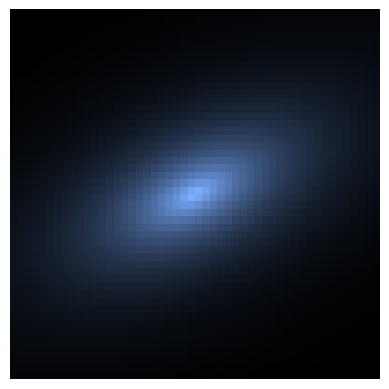

In [9]:
# Initialise Galaxy object
disk = Galaxy(stars=stars)

# Generate stellar spectra
incident = IncidentEmission(grid)
disk.stars.get_spectra(incident)

# Get photometry
disk.get_photo_lnu(filters)

# Make images
disk_img = disk.get_images_luminosity(
    resolution=resolution,
    fov=fov,
    emission_model=incident,
)

print(disk)

# Make and plot an rgb image
disk_img.make_rgb_image(rgb_filters={"R": "J", "G": "V", "B": "U"})
fig, ax, _ = disk_img.plot_rgb_image(show=True)

## Bulge

Lets do the same but make a Bulge this time to combine.

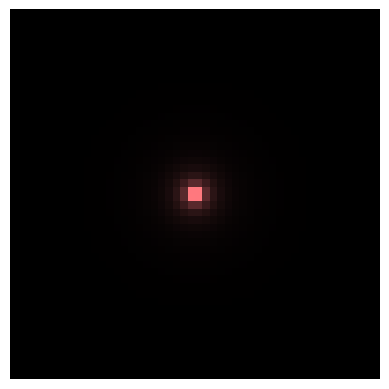

In [10]:
# Define bulge morphology
morph = Sersic2D(r_eff=0.5 * kpc, sersic_index=4.0)

# Define the parameters of the star formation and metal enrichment histories
stellar_mass = 10**9.2 * Msun
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=10.0 * Myr,
    metal_dist=0.01,
    morphology=morph,
    initial_mass=stellar_mass,
)

# Get galaxy object
bulge = Galaxy(stars=stars)

# Get spectra
bulge.stars.get_spectra(incident)

# Get photometry
bulge.get_photo_lnu(filters)

# make images
bulge_img = bulge.get_images_luminosity(
    resolution=resolution,
    fov=fov,
    emission_model=incident,
)

# Make and plot an rgb image
bulge_img.make_rgb_image(rgb_filters={"R": "J", "G": "V", "B": "U"})
fig, ax, _ = bulge_img.plot_rgb_image(show=True)

## Total

Finally we can combine the disk and bulge together to make a composite galaxy.

+-------------------------------------------------------------------------------+
|                                    GALAXY                                     |
+---------------+---------------------------------------------------------------+
| Attribute     | Value                                                         |
+---------------+---------------------------------------------------------------+
| galaxy_type   | 'Parametric'                                                  |
+---------------+---------------------------------------------------------------+
| stars         | <synthesizer.parametric.stars.Stars object at 0x7fbffb1b9900> |
+---------------+---------------------------------------------------------------+
| name          | 'parametric galaxy'                                           |
+---------------+---------------------------------------------------------------+
| sfzh (51, 13) | 0.00e+00 -> 1.91e+09 (Mean: 7.16e+06)                         |
+---------------

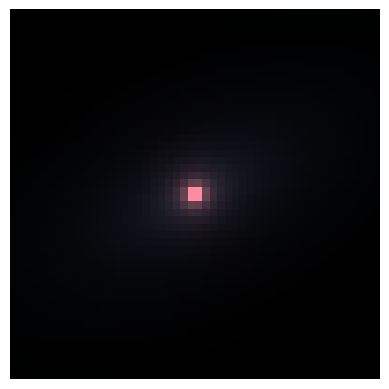

In [11]:
# Combine galaxy objects
combined = disk + bulge

print(combined)

# Combine images
total = disk_img + bulge_img

# Make and plot an rgb image
total.make_rgb_image(rgb_filters={"R": "J", "G": "V", "B": "U"})
fig, ax, _ = total.plot_rgb_image(show=True)

And plot the spectra for good measure...

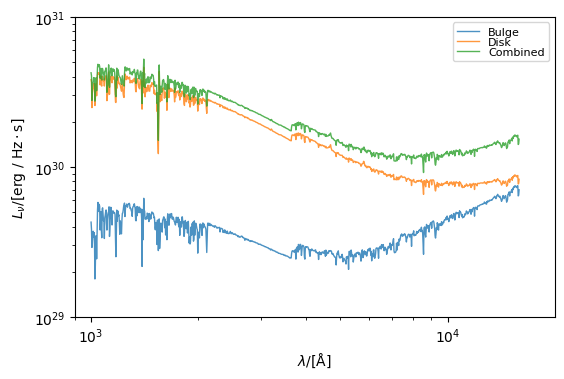

(<Figure size 600x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{\\AA}]$', ylabel='$L_{\\nu}/[\\mathrm{\\rm{erg} \\ / \\ \\rm{Hz \\cdot \\rm{s}}}]$'>)

In [12]:
from synthesizer.sed import plot_spectra

plot_spectra(
    spectra={"Combined": combined.stars.spectra["incident"], "Disk": disk.stars.spectra["incident"], "Bulge": bulge.stars.spectra["incident"],},
    show=True,
    ylimits=(10**29., 10**31.),
    xlimits=(900, 10**4.3),
    figsize=(6, 5)
)